# Homework 03: Learning Curves and Training Workflow

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

In this homework, you will use **early stopping** to select the "best" model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance. Test accuracy is reported for reference but is not used for model selection.

> **Note:** Throughout this homework, best always refers to the model selected by early stopping at the epoch of minimum validation loss. Do not report metrics from the final training epoch unless explicitly instructed.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework.

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training.

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This data set is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced.

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set.


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters.

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained.

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline Model - RelU



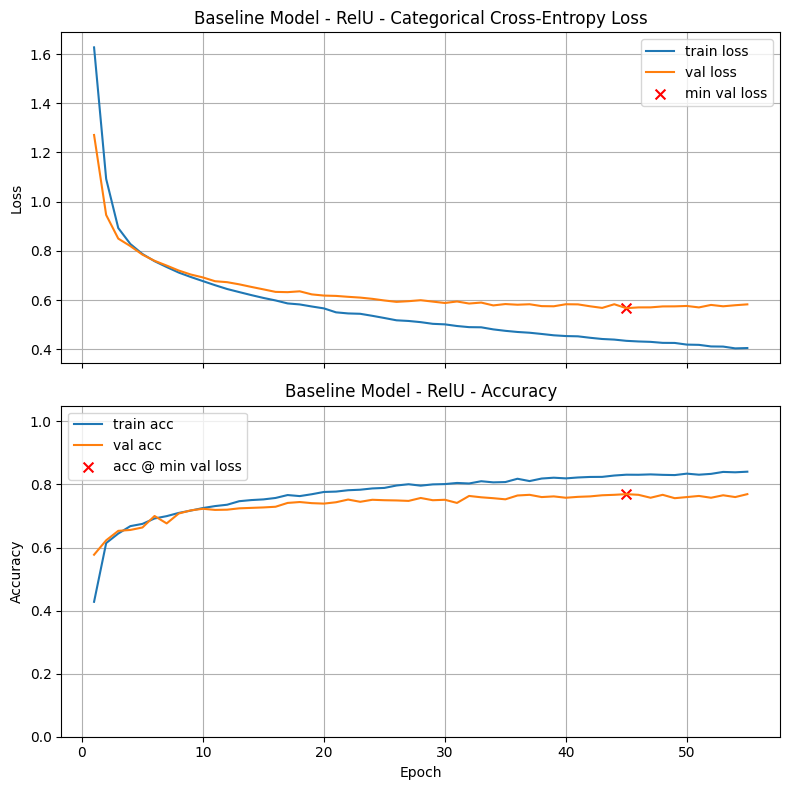

Final Training Loss:            0.4048
Final Training Accuracy:        0.8405
Final Validation Loss:          0.5824
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.5669 (Epoch 45)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.5914
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:19


In [9]:
# Your code here. Add as many cells as you need.
model_baseline_relu = build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.0,0.0)], n_classes)

train_and_test(model_baseline_relu, title = "Baseline Model - RelU")



Baseline Model - Sigmoid



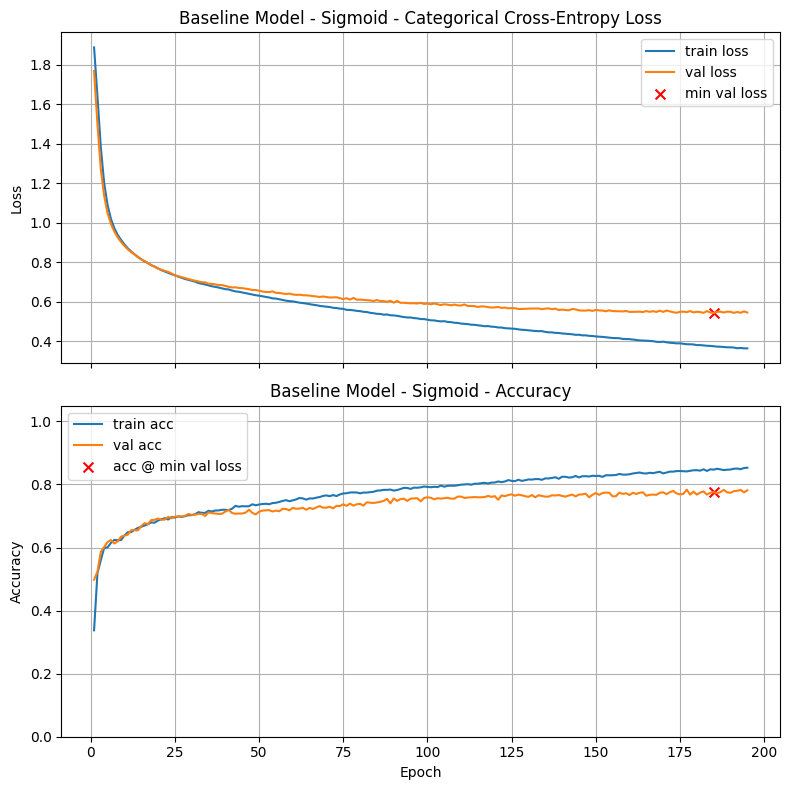

Final Training Loss:            0.3646
Final Training Accuracy:        0.8531
Final Validation Loss:          0.5461
Final Validation Accuracy:      0.7814
Minimum Validation Loss:        0.5437 (Epoch 185)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5742
Test Accuracy: 0.7793

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:57


In [10]:
model_baseline_sigmoid = build_model(X_train.shape[1], [ (64,'sigmoid',0.0,0.0), (32,'sigmoid',0.0,0.0)], n_classes)

train_and_test(model_baseline_sigmoid, title = "Baseline Model - Sigmoid")


Baseline Model - TanH



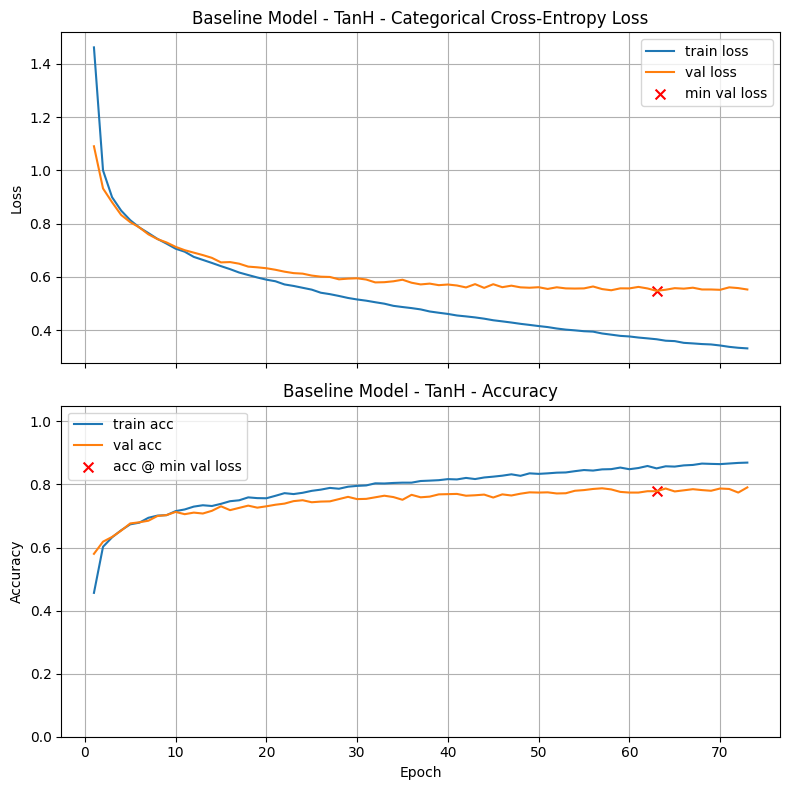

Final Training Loss:            0.3322
Final Training Accuracy:        0.8693
Final Validation Loss:          0.5531
Final Validation Accuracy:      0.7907
Minimum Validation Loss:        0.5481 (Epoch 63)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.5592
Test Accuracy: 0.7729

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:24


In [11]:
model_baseline_tanh = build_model(X_train.shape[1], [ (64,'tanh',0.0,0.0), (32,'tanh',0.0,0.0)], n_classes)

train_and_test(model_baseline_tanh, title = "Baseline Model - TanH")

In [12]:
best_act = 'tanh'

### Graded Questions

In [13]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [14]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 2


In [16]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7786             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7786


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Baseline Model - LR = 0.001



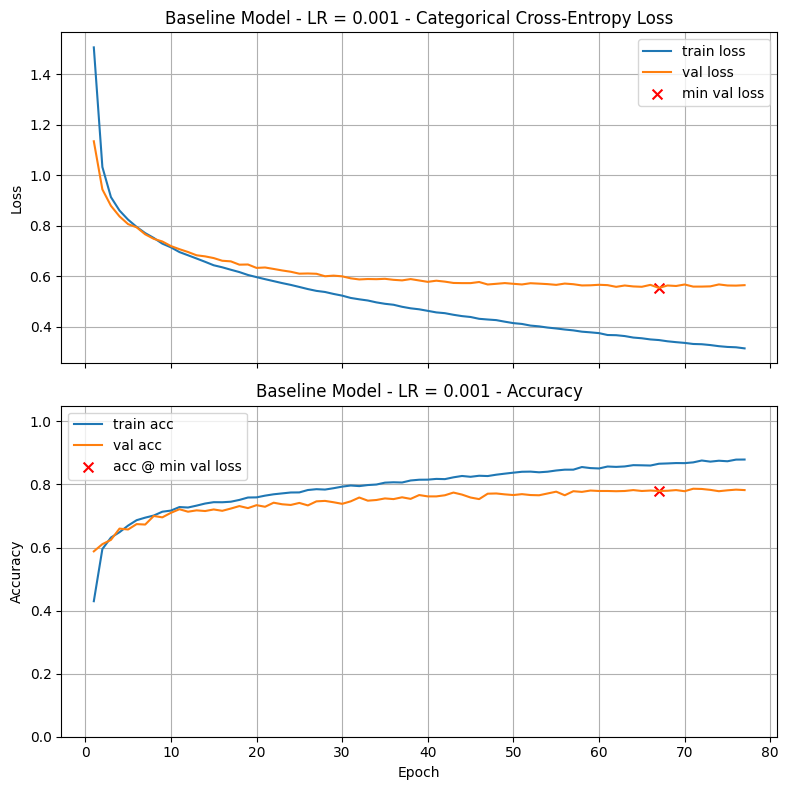

Final Training Loss:            0.3145
Final Training Accuracy:        0.8790
Final Validation Loss:          0.5650
Final Validation Accuracy:      0.7821
Minimum Validation Loss:        0.5541 (Epoch 67)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5579
Test Accuracy: 0.7671

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:25

Baseline Model - LR = 0.0005



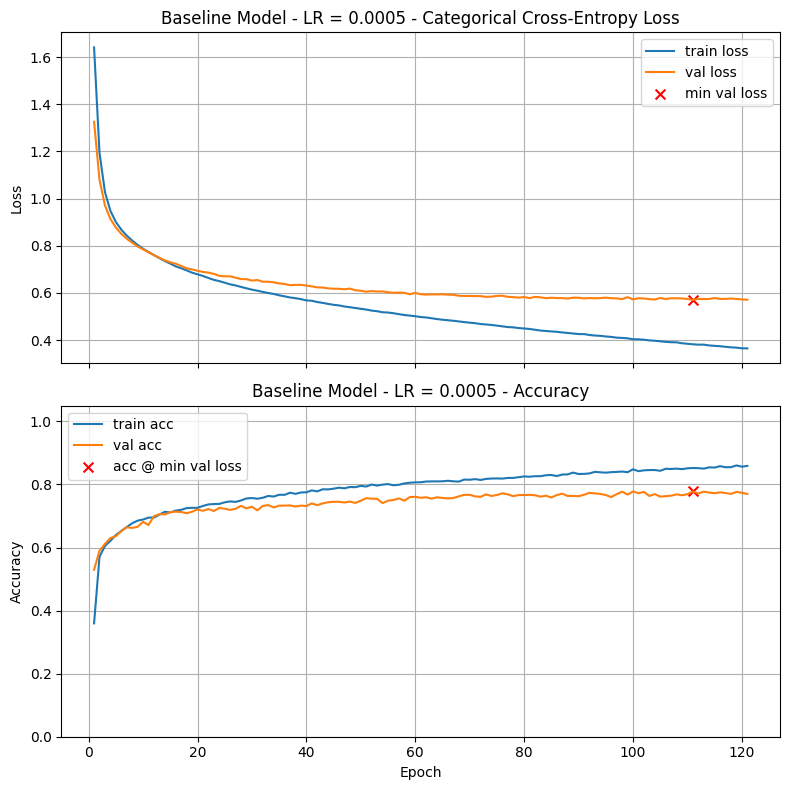

Final Training Loss:            0.3651
Final Training Accuracy:        0.8588
Final Validation Loss:          0.5711
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5704 (Epoch 111)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.5821
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:36

Baseline Model - LR = 0.0001



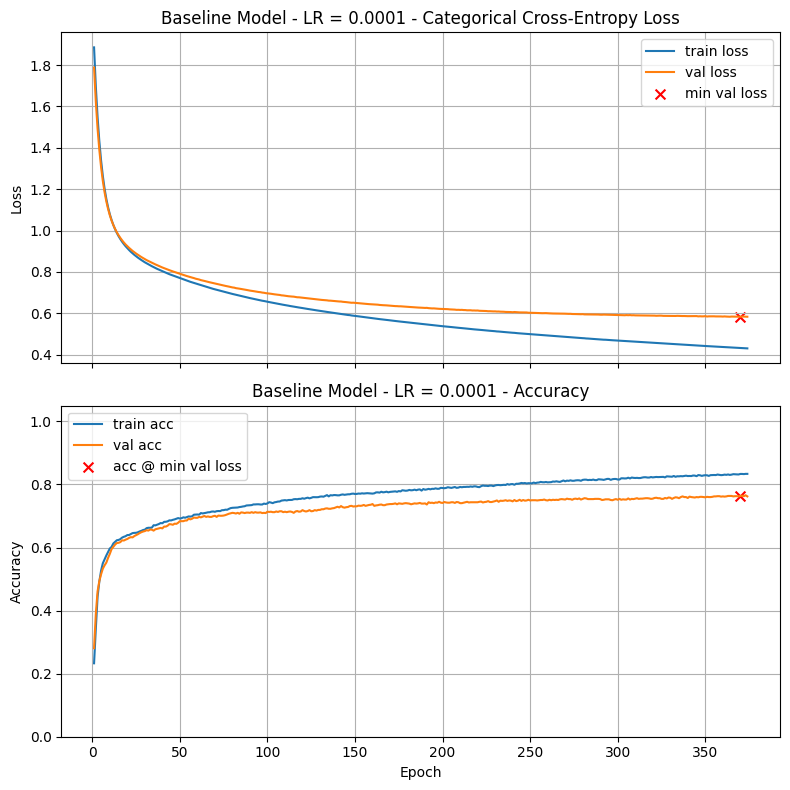

Final Training Loss:            0.4303
Final Training Accuracy:        0.8336
Final Validation Loss:          0.5833
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.5833 (Epoch 370)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6086
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:01:42

Baseline Model - LR = 5e-05



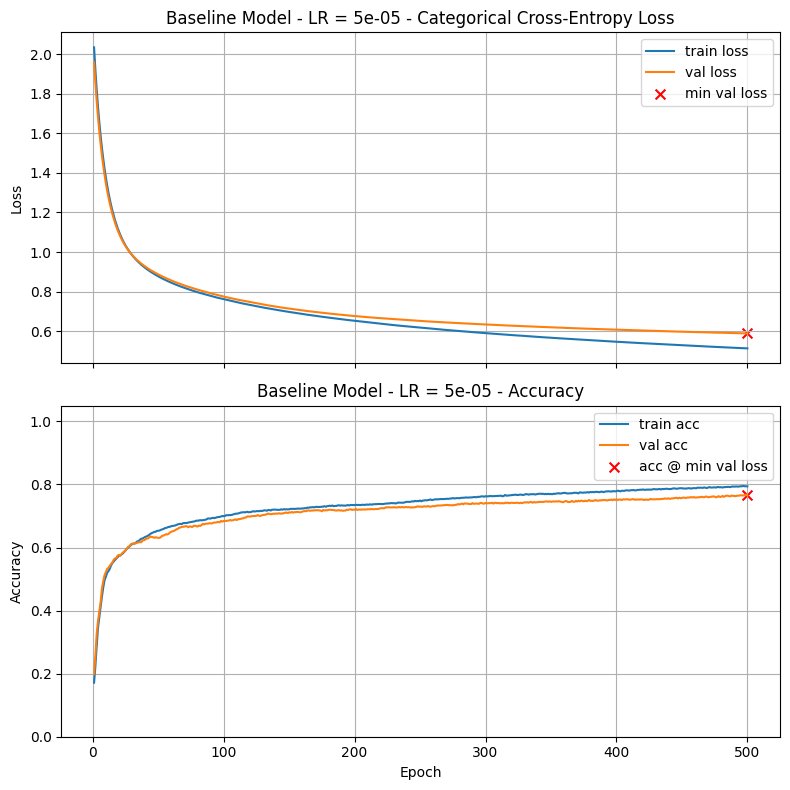

Final Training Loss:            0.5133
Final Training Accuracy:        0.7940
Final Validation Loss:          0.5889
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.5889 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6095
Test Accuracy: 0.7329

Validation-Test Gap (accuracy): 0.034286

Execution Time: 00:02:14

Baseline Model - LR = 1e-05



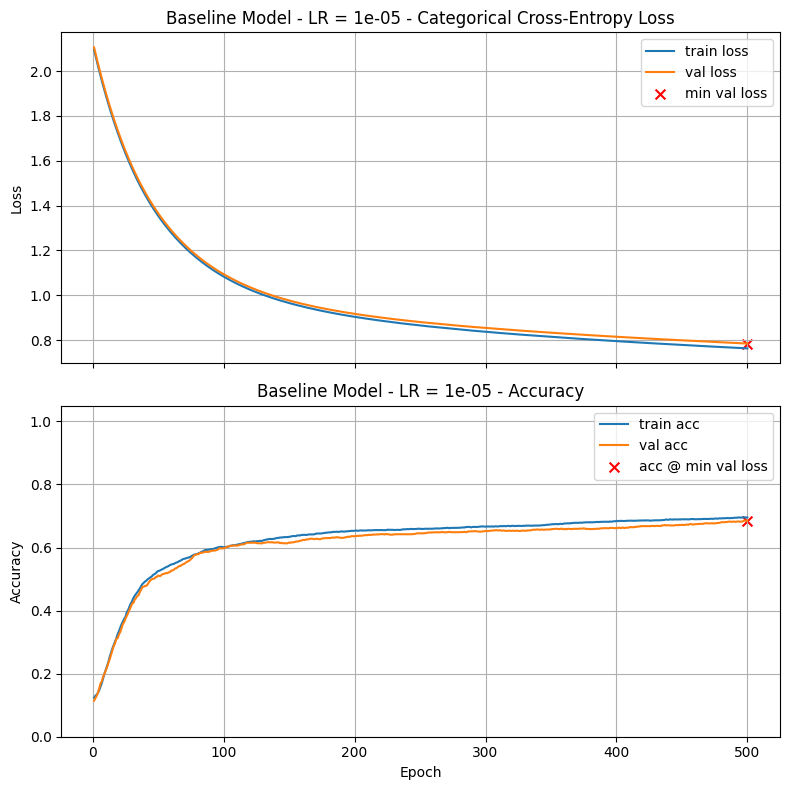

Final Training Loss:            0.7628
Final Training Accuracy:        0.6952
Final Validation Loss:          0.7843
Final Validation Accuracy:      0.6850
Minimum Validation Loss:        0.7843 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6850

Test Loss: 0.8012
Test Accuracy: 0.6829

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:02:18


In [18]:
# Your code here. Add as many cells as you need.
for lr_ in [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]:
  model_baseline = build_model(X_train.shape[1], [ (64,best_act,0.0,0.0), (32,best_act,0.0,0.0)], n_classes)

  train_and_test(model_baseline, lr_schedule=lr_,  title = f"Baseline Model - LR = {lr_}")

In [19]:
best_lr = 1e-3

#### Graded Questions

In [20]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = best_lr           # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.6f}')

a2a = 0.001000


In [22]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7793             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7793


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline Model - DR_64 = 0.0, DR_32 = 0.3



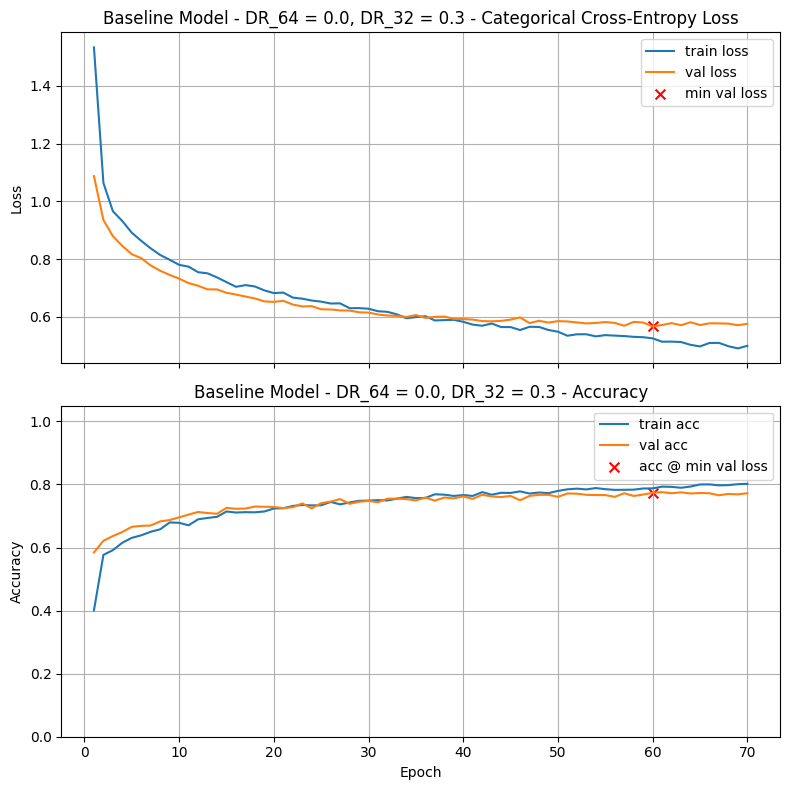

Final Training Loss:            0.4995
Final Training Accuracy:        0.8019
Final Validation Loss:          0.5758
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.5667 (Epoch 60)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.6115
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:25

Baseline Model - DR_64 = 0.0, DR_32 = 0.4



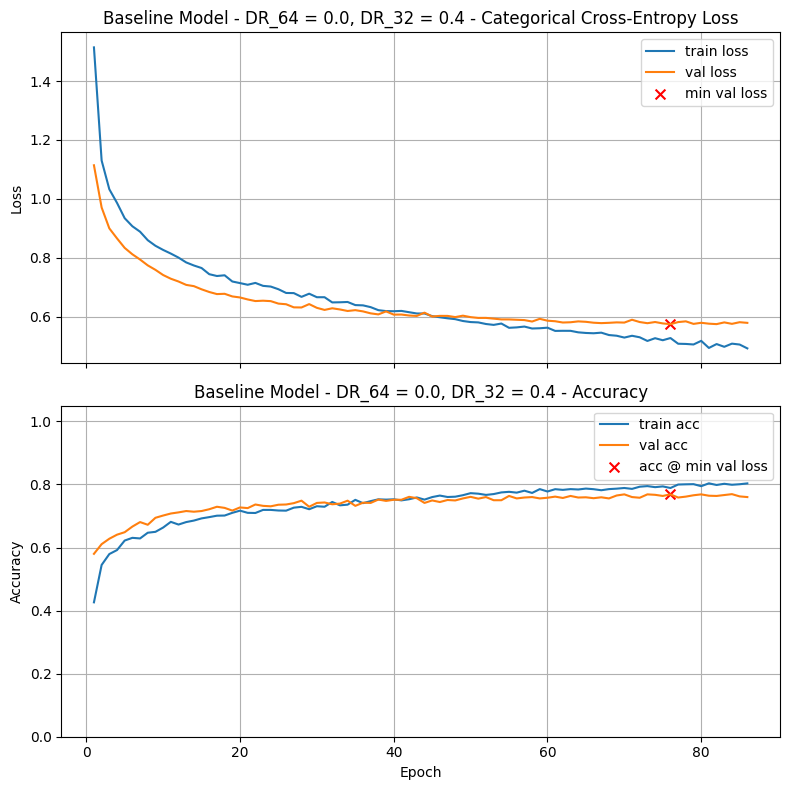

Final Training Loss:            0.4920
Final Training Accuracy:        0.8033
Final Validation Loss:          0.5787
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.5742 (Epoch 76)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.5996
Test Accuracy: 0.7686

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:28

Baseline Model - DR_64 = 0.0, DR_32 = 0.5



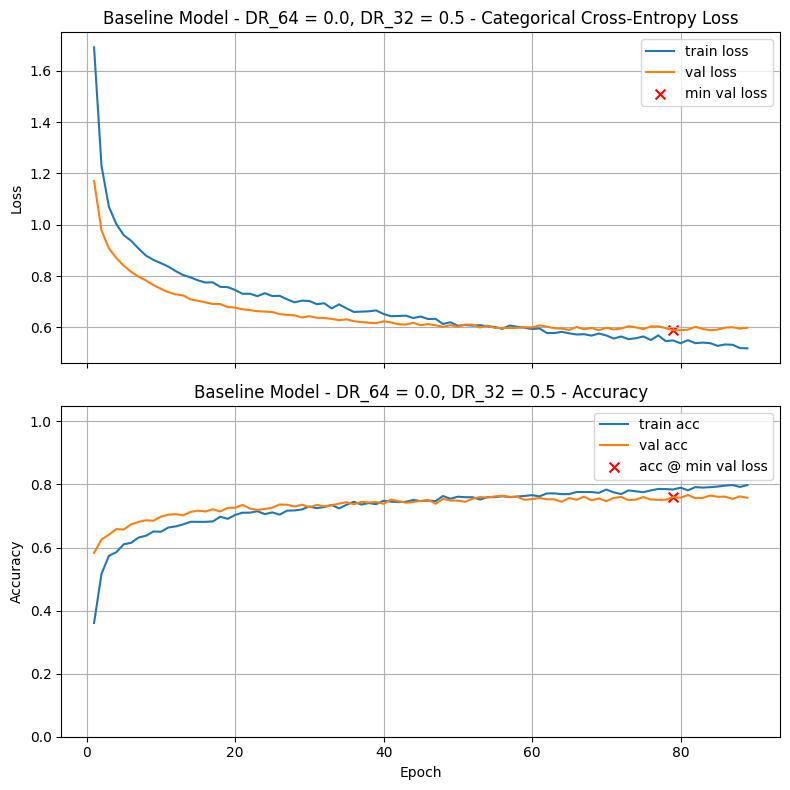

Final Training Loss:            0.5181
Final Training Accuracy:        0.7979
Final Validation Loss:          0.5984
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.5883 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6240
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:30

Baseline Model - DR_64 = 0.1, DR_32 = 0.3



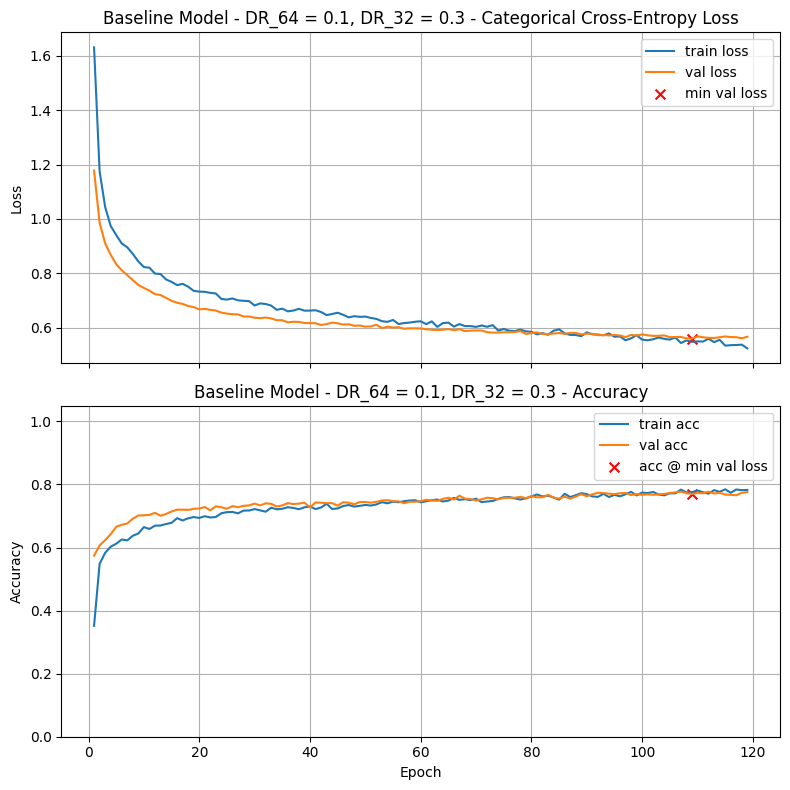

Final Training Loss:            0.5240
Final Training Accuracy:        0.7826
Final Validation Loss:          0.5666
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5598 (Epoch 109)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5813
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:39

Baseline Model - DR_64 = 0.1, DR_32 = 0.4



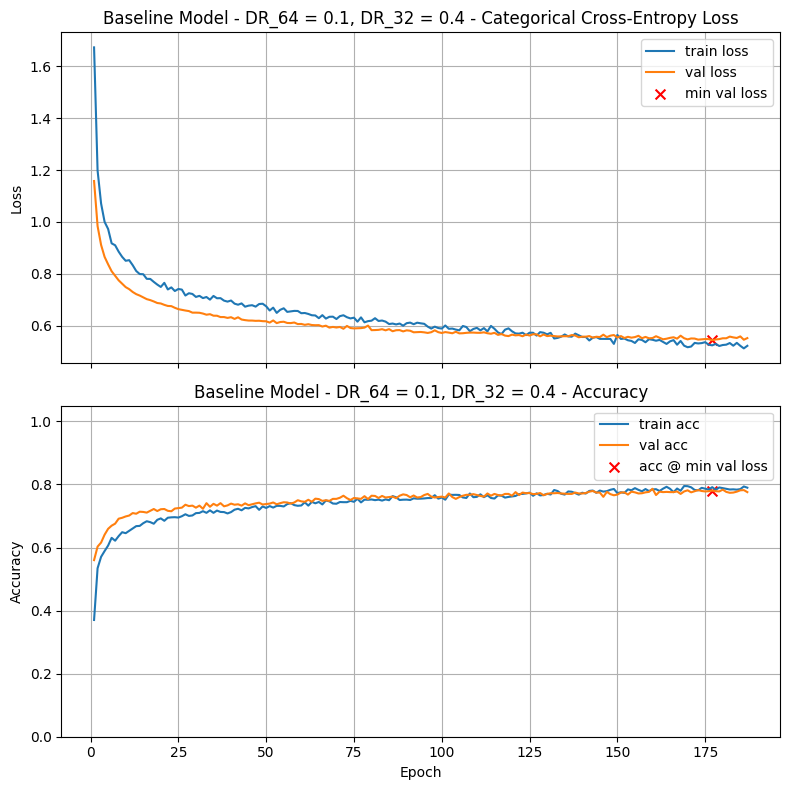

Final Training Loss:            0.5229
Final Training Accuracy:        0.7898
Final Validation Loss:          0.5527
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5444 (Epoch 177)
Validation Accuracy @ Min Loss: 0.7807

Test Loss: 0.5747
Test Accuracy: 0.7721

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:58

Baseline Model - DR_64 = 0.1, DR_32 = 0.5



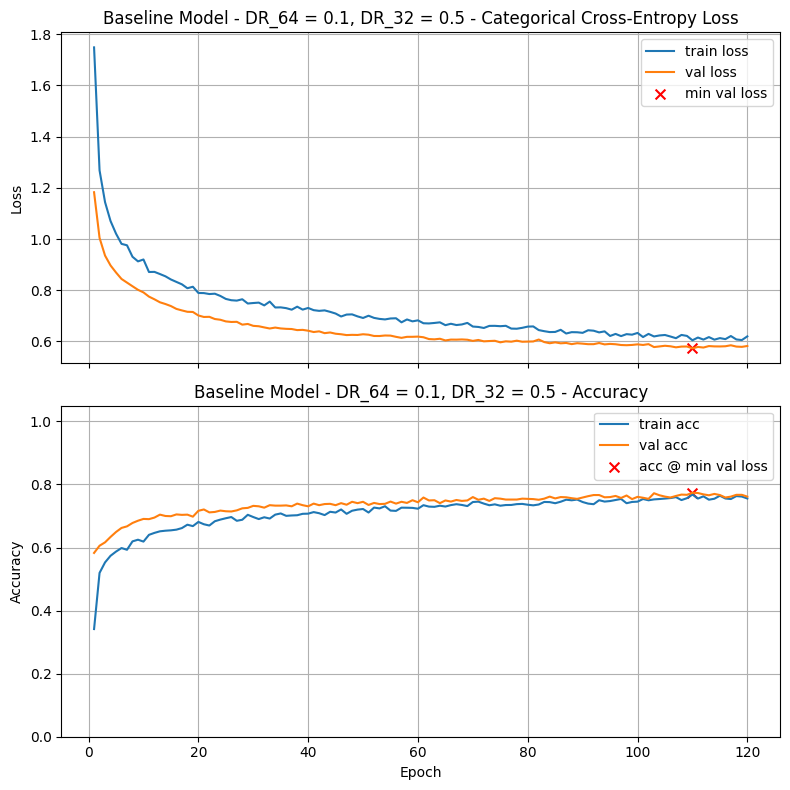

Final Training Loss:            0.6200
Final Training Accuracy:        0.7555
Final Validation Loss:          0.5824
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5731 (Epoch 110)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.6130
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:38

Baseline Model - DR_64 = 0.2, DR_32 = 0.3



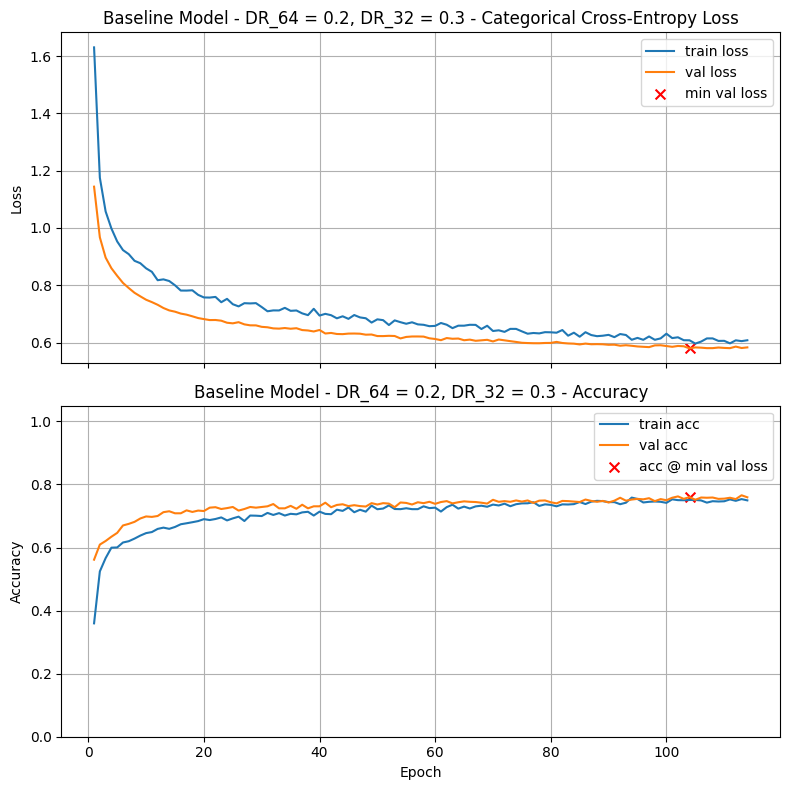

Final Training Loss:            0.6081
Final Training Accuracy:        0.7495
Final Validation Loss:          0.5832
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.5798 (Epoch 104)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6045
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:37

Baseline Model - DR_64 = 0.2, DR_32 = 0.4



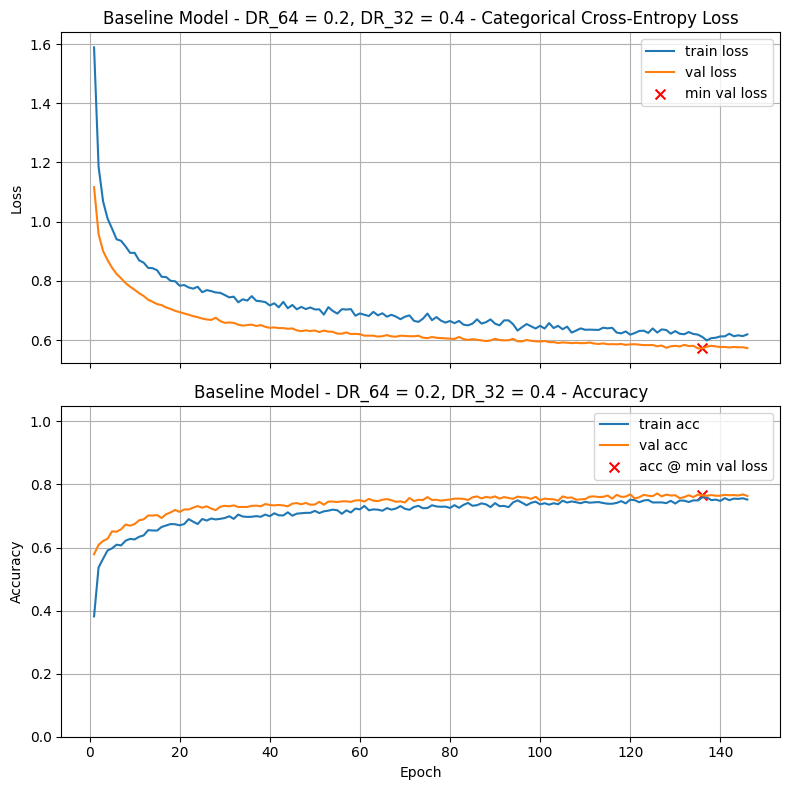

Final Training Loss:            0.6192
Final Training Accuracy:        0.7521
Final Validation Loss:          0.5727
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5718 (Epoch 136)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6077
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:46

Baseline Model - DR_64 = 0.2, DR_32 = 0.5



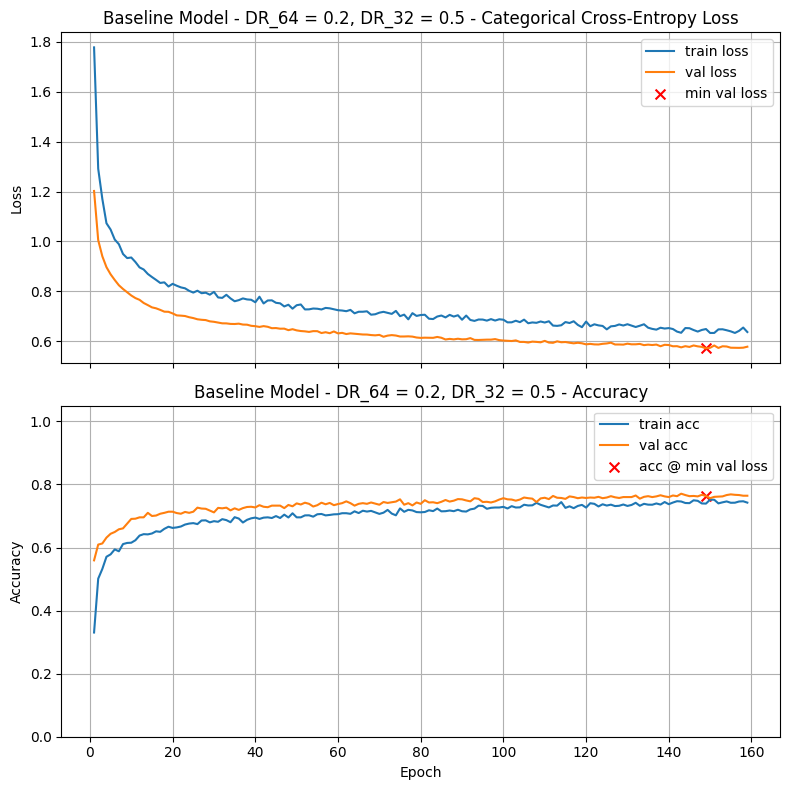

Final Training Loss:            0.6369
Final Training Accuracy:        0.7424
Final Validation Loss:          0.5781
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5713 (Epoch 149)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6110
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:49


In [24]:
# Your code here. Add as many cells as you need.
drop_64 = [0.0, 0.1, 0.2]
drop_32 = [0.3, 0.4, 0.5]

for dr_64 in drop_64:
  for dr_32 in drop_32:
    model_baseline = build_model(X_train.shape[1], [ (64,best_act,0.0,dr_64), (32,best_act,0.0,dr_32)], n_classes)

    train_and_test(model_baseline, lr_schedule=best_lr,  title = f"Baseline Model - DR_64 = {dr_64}, DR_32 = {dr_32}")


In [25]:
best_drop_64 = 0.1
best_drop_32 = 0.4

In [26]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a3a = (best_drop_64,best_drop_32)             # Replace (0.0,0.0) with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')

a3a = (0.1, 0.4)


In [28]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7807             # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.7807


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline Model - L2_64 = 0.0001, L2_32 = 0.0001



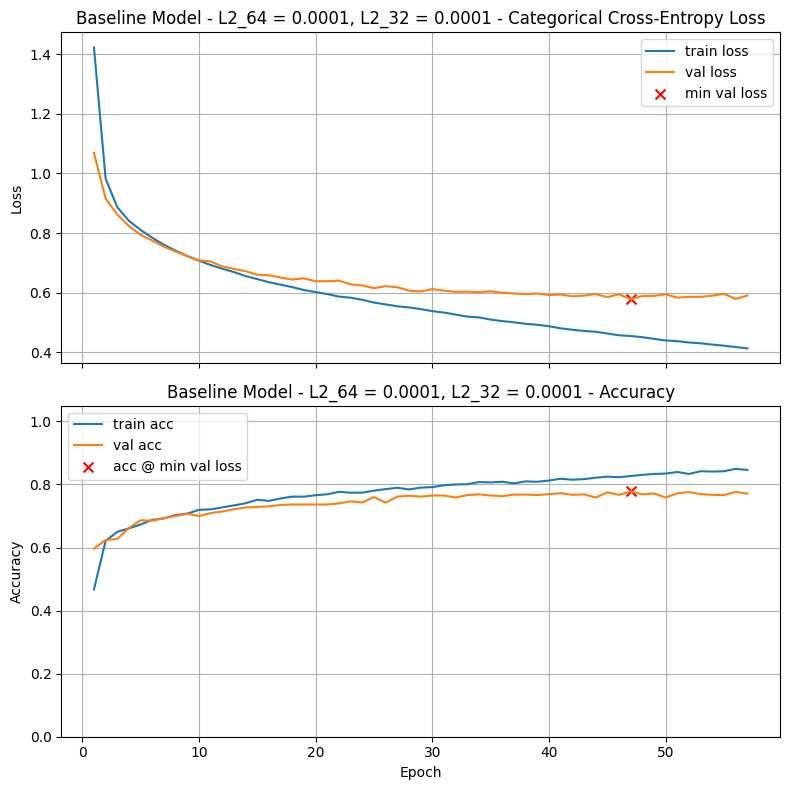

Final Training Loss:            0.4127
Final Training Accuracy:        0.8462
Final Validation Loss:          0.5900
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5774 (Epoch 47)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.5929
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:00:19

Baseline Model - L2_64 = 0.0001, L2_32 = 0.001



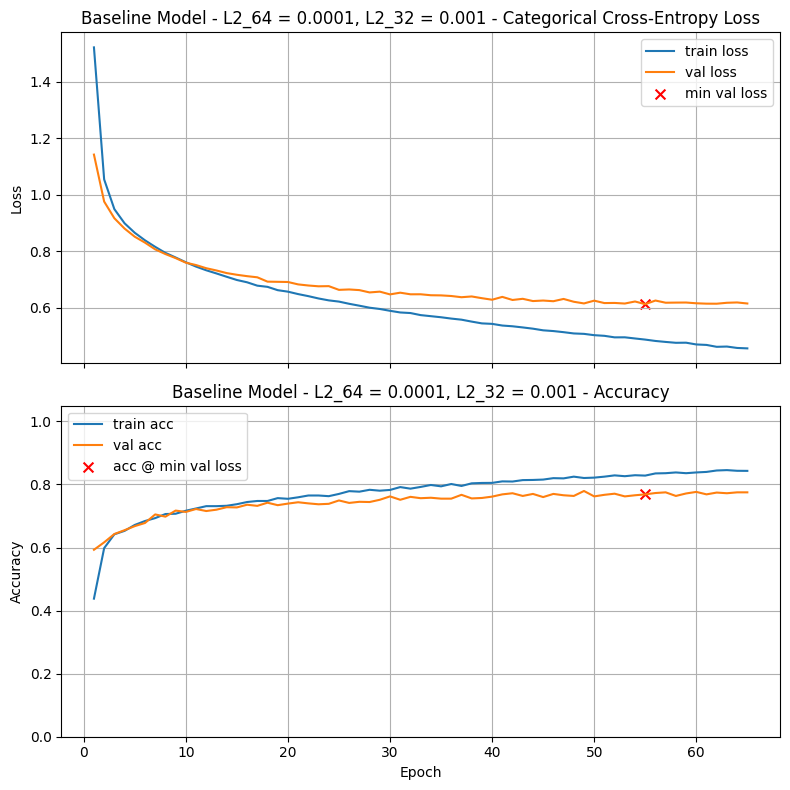

Final Training Loss:            0.4561
Final Training Accuracy:        0.8431
Final Validation Loss:          0.6148
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6125 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6280
Test Accuracy: 0.7657

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:22

Baseline Model - L2_64 = 0.0001, L2_32 = 0.01



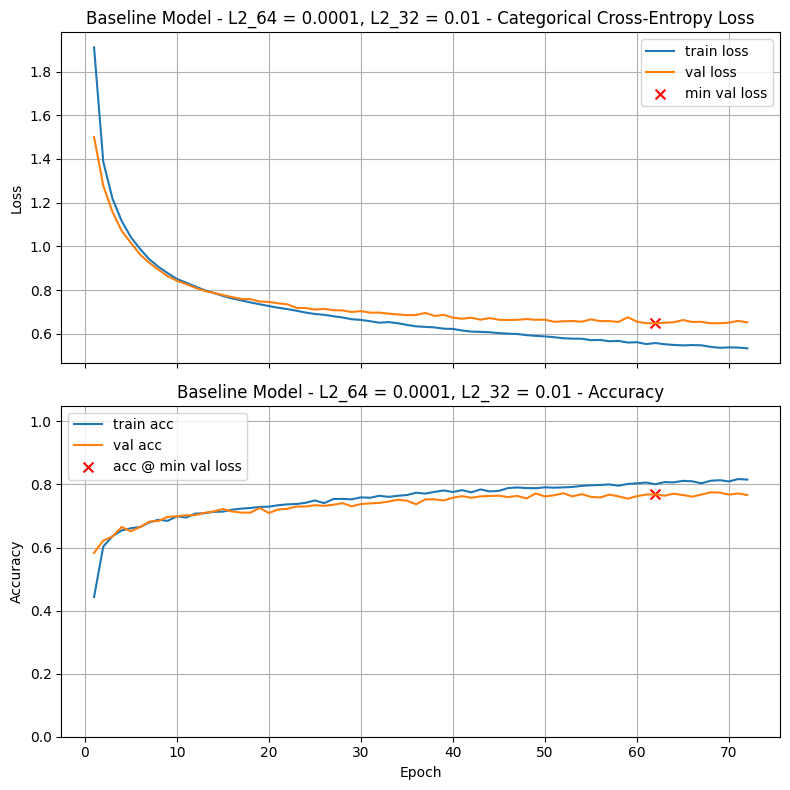

Final Training Loss:            0.5332
Final Training Accuracy:        0.8155
Final Validation Loss:          0.6524
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.6482 (Epoch 62)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6630
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:23

Baseline Model - L2_64 = 0.001, L2_32 = 0.0001



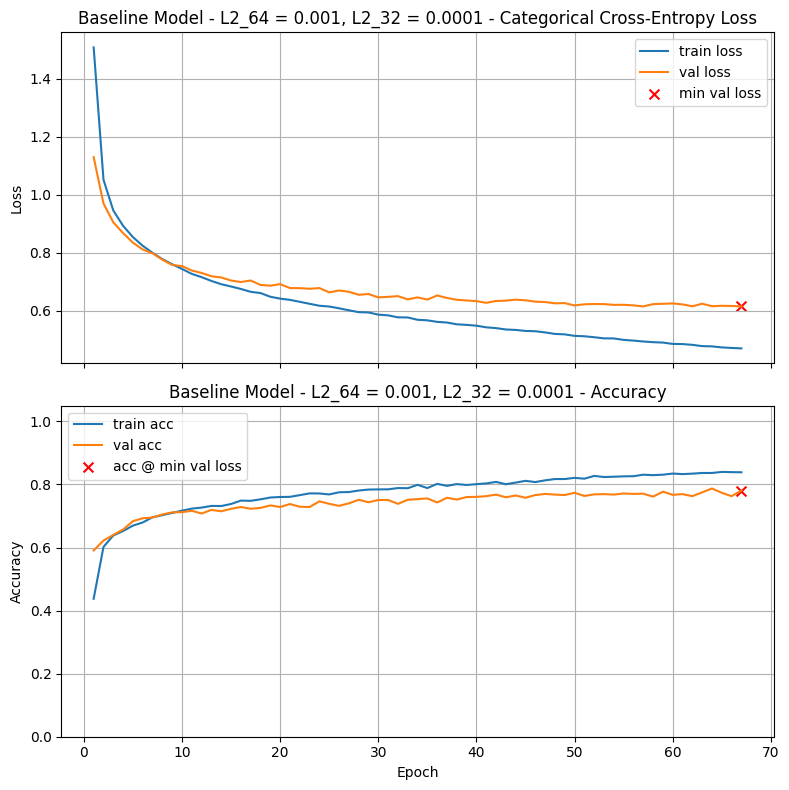

Final Training Loss:            0.4695
Final Training Accuracy:        0.8386
Final Validation Loss:          0.6143
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.6143 (Epoch 67)
Validation Accuracy @ Min Loss: 0.7807

Test Loss: 0.6376
Test Accuracy: 0.7479

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:22

Baseline Model - L2_64 = 0.001, L2_32 = 0.001



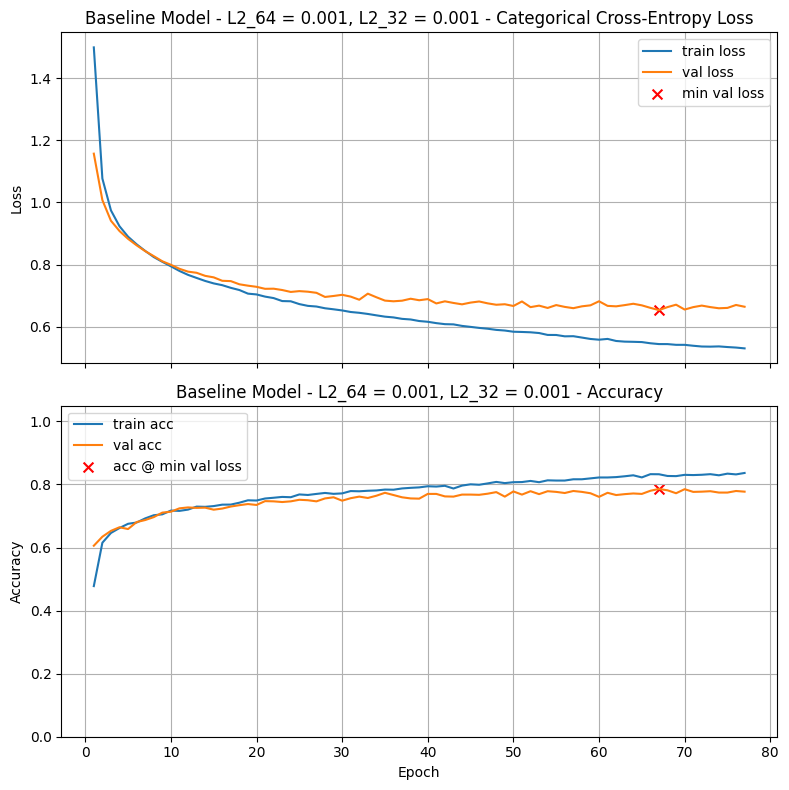

Final Training Loss:            0.5298
Final Training Accuracy:        0.8364
Final Validation Loss:          0.6640
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.6532 (Epoch 67)
Validation Accuracy @ Min Loss: 0.7857

Test Loss: 0.6637
Test Accuracy: 0.7714

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:26

Baseline Model - L2_64 = 0.001, L2_32 = 0.01



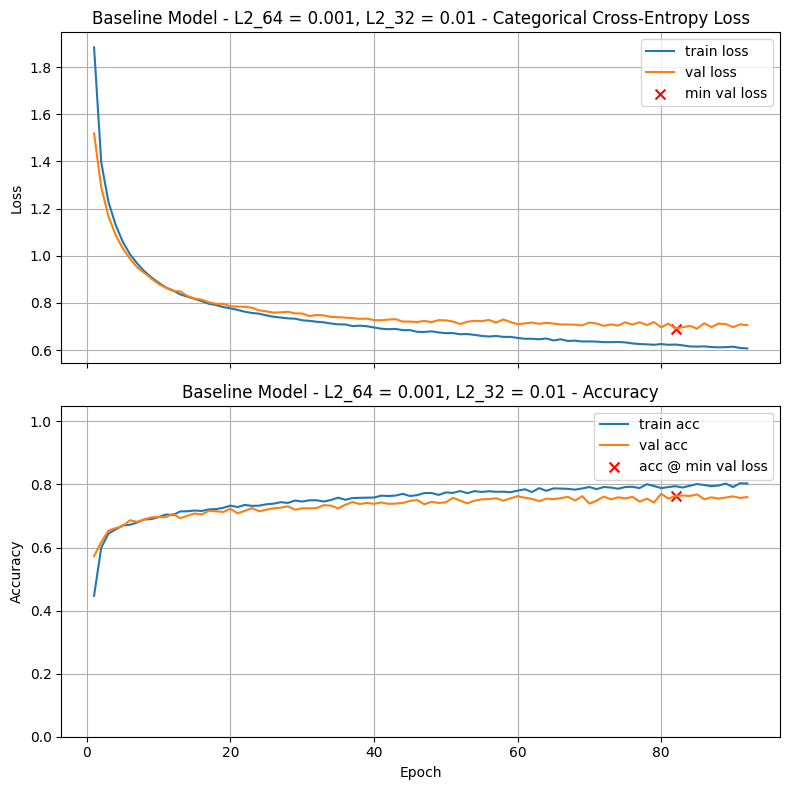

Final Training Loss:            0.6069
Final Training Accuracy:        0.8031
Final Validation Loss:          0.7055
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.6908 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.7166
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:32

Baseline Model - L2_64 = 0.01, L2_32 = 0.0001



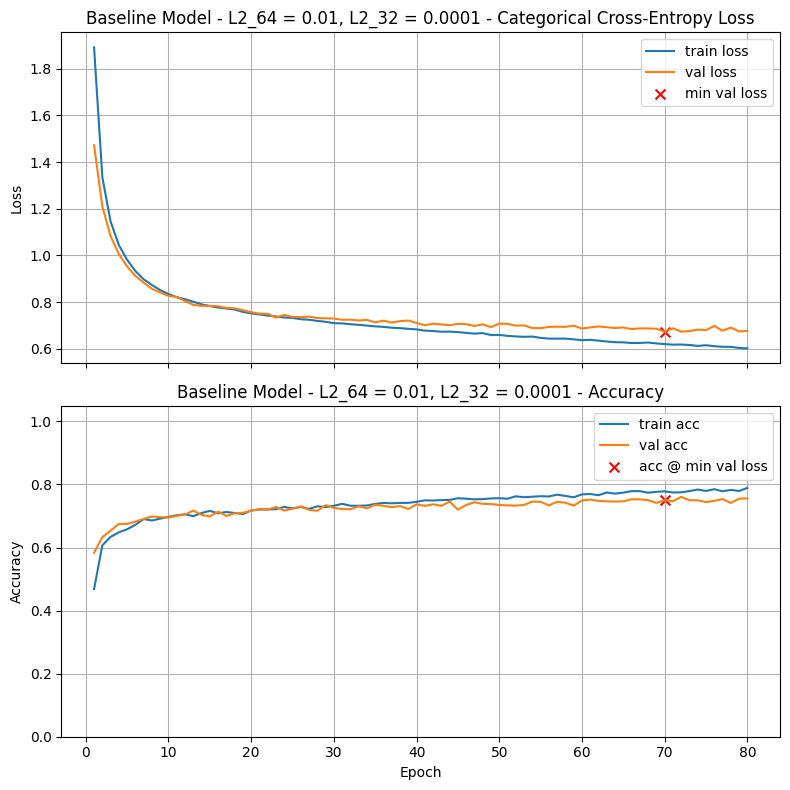

Final Training Loss:            0.6012
Final Training Accuracy:        0.7890
Final Validation Loss:          0.6760
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6730 (Epoch 70)
Validation Accuracy @ Min Loss: 0.7500

Test Loss: 0.6929
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:26

Baseline Model - L2_64 = 0.01, L2_32 = 0.001



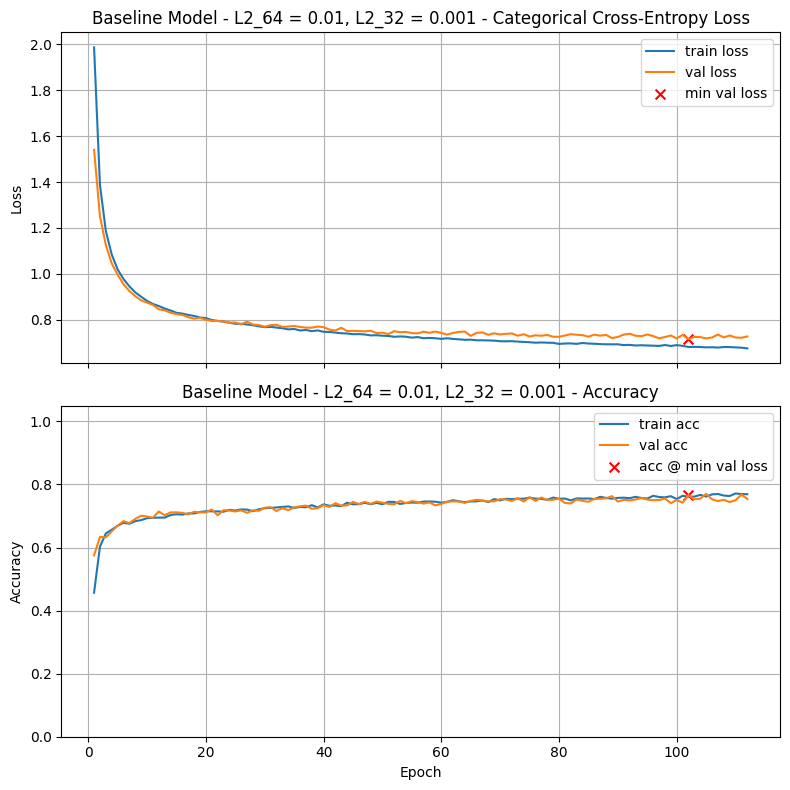

Final Training Loss:            0.6758
Final Training Accuracy:        0.7690
Final Validation Loss:          0.7276
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.7163 (Epoch 102)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.7386
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.029286

Execution Time: 00:00:36

Baseline Model - L2_64 = 0.01, L2_32 = 0.01



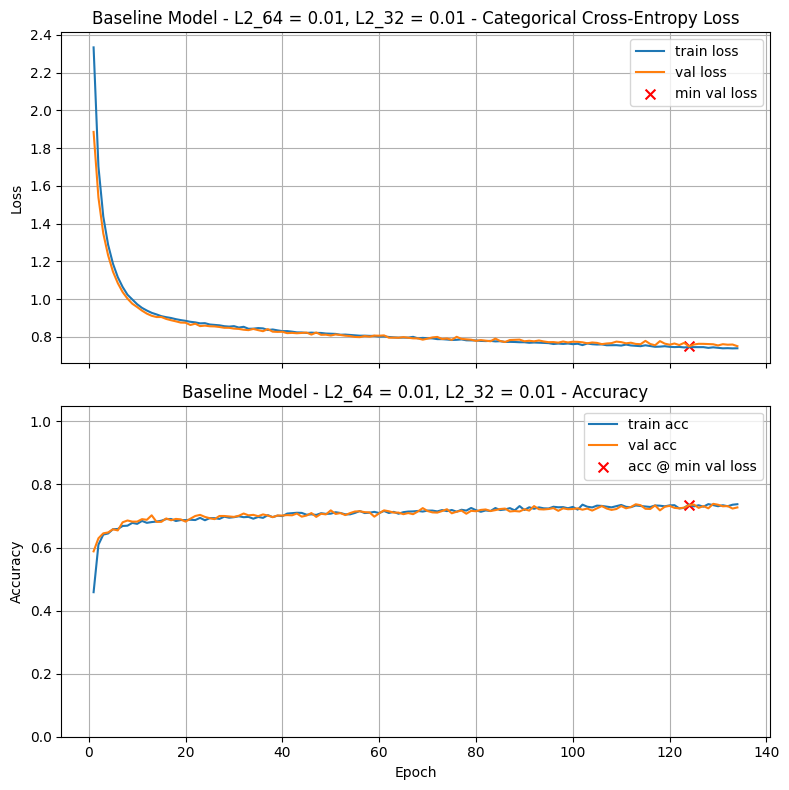

Final Training Loss:            0.7400
Final Training Accuracy:        0.7374
Final Validation Loss:          0.7511
Final Validation Accuracy:      0.7271
Minimum Validation Loss:        0.7500 (Epoch 124)
Validation Accuracy @ Min Loss: 0.7343

Test Loss: 0.7810
Test Accuracy: 0.7221

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:40


In [30]:
# Your code here. Add as many cells as you need.
lambda_64 = [1e-4, 1e-3, 1e-2]
lambda_32 = [1e-4, 1e-3, 1e-2]

for l2_64 in lambda_64:
  for l2_32 in lambda_32:
    model_baseline = build_model(X_train.shape[1], [ (64,best_act,l2_64,0.0), (32,best_act,l2_32,0.0)], n_classes)

    train_and_test(model_baseline, lr_schedule=best_lr,  title = f"Baseline Model - L2_64 = {l2_64}, L2_32 = {l2_32}")

In [31]:
best_l2_64 = 1e-3
best_l2_32 = 1e-3

In [32]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best
# validation accuracy at the epoch of minimum validation loss

a4a = (best_l2_64,best_l2_32)             # Replace (0.0,0.0) with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a}')

a4a = (0.001, 0.001)


In [34]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7857             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.7857


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Baseline Model w Best Dropout - L2 = 0.0001



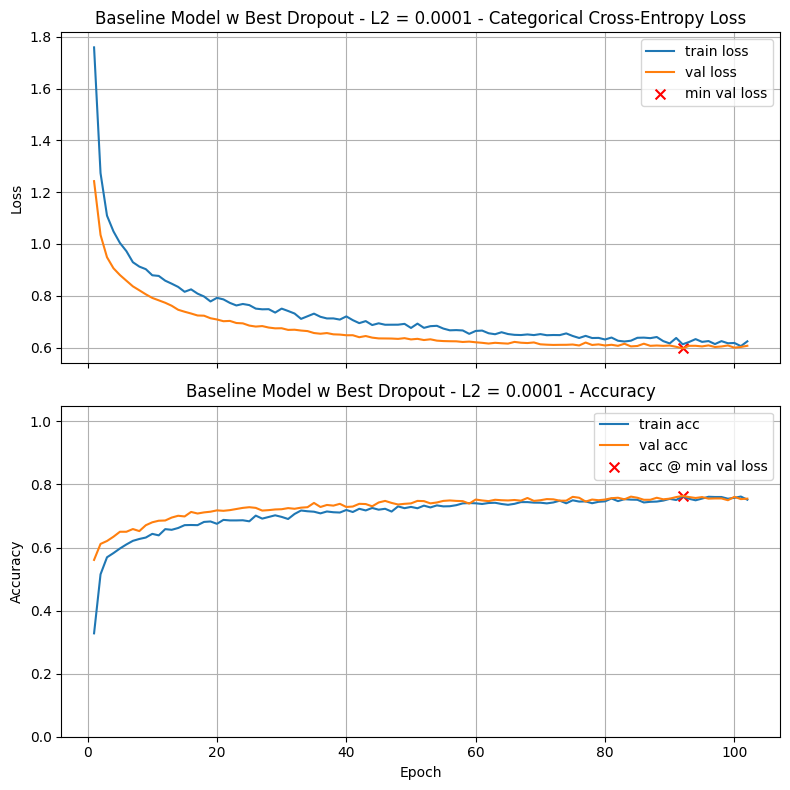

Final Training Loss:            0.6239
Final Training Accuracy:        0.7517
Final Validation Loss:          0.6067
Final Validation Accuracy:      0.7550
Minimum Validation Loss:        0.5967 (Epoch 92)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6289
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:35

Baseline Model w Best Dropout - L2 = 0.001



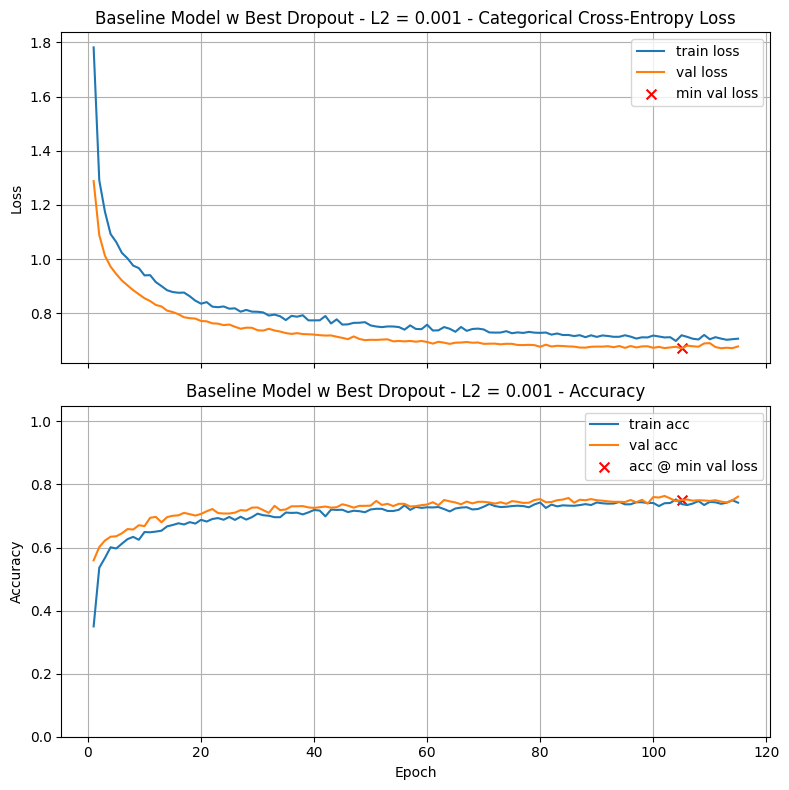

Final Training Loss:            0.7057
Final Training Accuracy:        0.7421
Final Validation Loss:          0.6771
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.6699 (Epoch 105)
Validation Accuracy @ Min Loss: 0.7507

Test Loss: 0.7027
Test Accuracy: 0.7407

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:37

Baseline Model w Best Dropout - L2 = 0.01



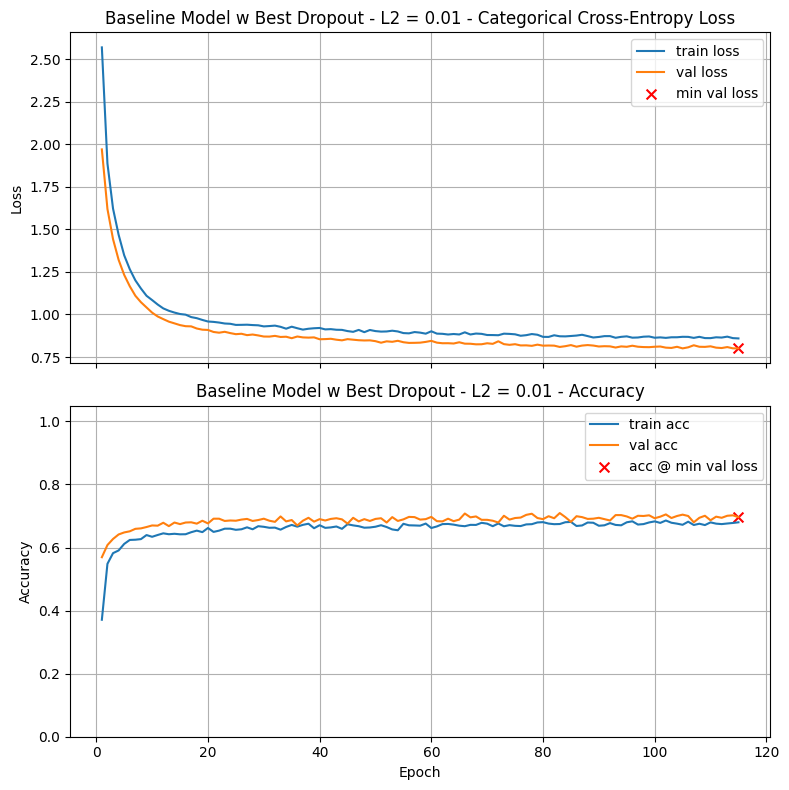

Final Training Loss:            0.8593
Final Training Accuracy:        0.6800
Final Validation Loss:          0.8008
Final Validation Accuracy:      0.6964
Minimum Validation Loss:        0.8008 (Epoch 115)
Validation Accuracy @ Min Loss: 0.6964

Test Loss: 0.8247
Test Accuracy: 0.7064

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:37


In [36]:
# Your code here. Add as many cells as you need.
lambdas = [1e-4, 1e-3, 1e-2]

for l2_ in lambdas:
  model_baseline = build_model(X_train.shape[1], [ (64,best_act,l2_,best_drop_64), (32,best_act,l2_,best_drop_32)], n_classes)

  train_and_test(model_baseline, lr_schedule=best_lr,  title = f"Baseline Model w Best Dropout - L2 = {l2_}")


Baseline Model w Reduced Dropout - L2 = 0.0001



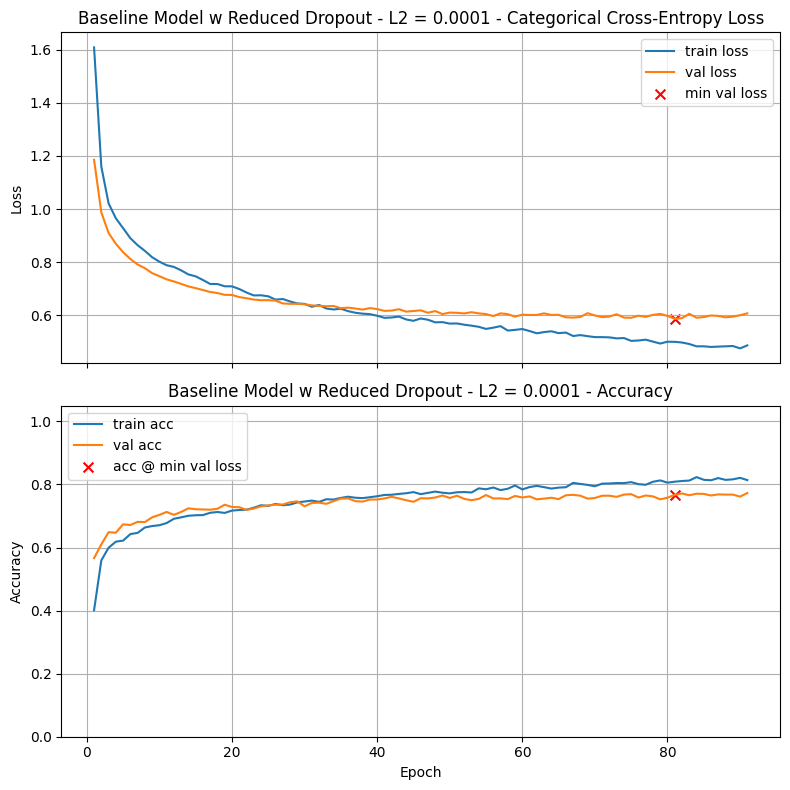

Final Training Loss:            0.4862
Final Training Accuracy:        0.8138
Final Validation Loss:          0.6069
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5860 (Epoch 81)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6262
Test Accuracy: 0.7450

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:29

Baseline Model w Reduced Dropout - L2 = 0.001



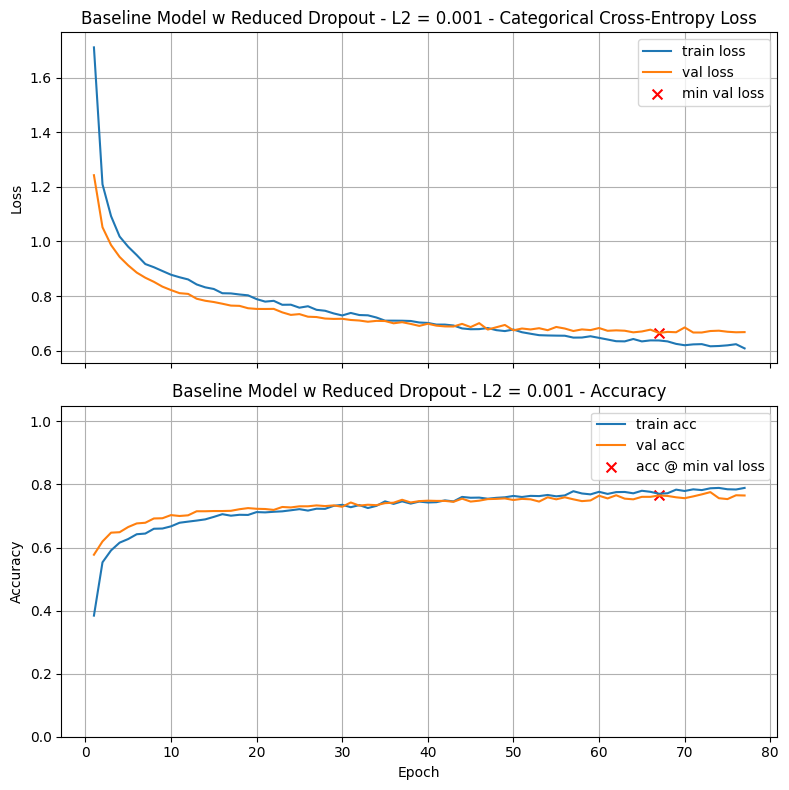

Final Training Loss:            0.6084
Final Training Accuracy:        0.7890
Final Validation Loss:          0.6680
Final Validation Accuracy:      0.7650
Minimum Validation Loss:        0.6649 (Epoch 67)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.7111
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:27

Baseline Model w Reduced Dropout - L2 = 0.01



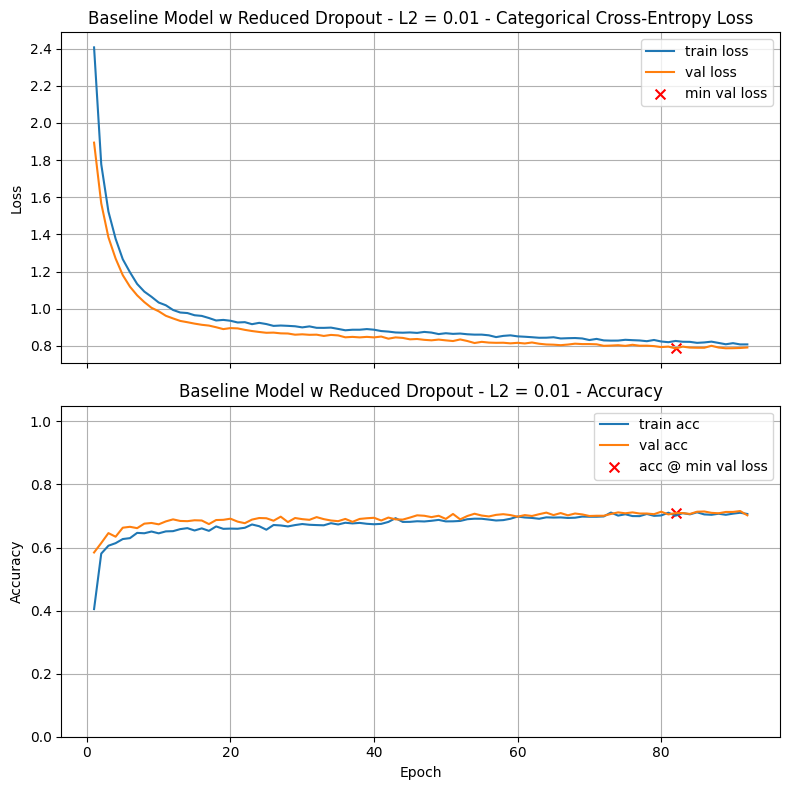

Final Training Loss:            0.8083
Final Training Accuracy:        0.7064
Final Validation Loss:          0.7917
Final Validation Accuracy:      0.7021
Minimum Validation Loss:        0.7869 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7093

Test Loss: 0.8163
Test Accuracy: 0.6957

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:30


In [37]:
lambdas = [1e-4, 1e-3, 1e-2]

for l2_ in lambdas:
  model_baseline = build_model(X_train.shape[1], [ (64,best_act,l2_,best_drop_64-0.1), (32,best_act,l2_,best_drop_32-0.1)], n_classes)

  train_and_test(model_baseline, lr_schedule=best_lr,  title = f"Baseline Model w Reduced Dropout - L2 = {l2_}")

In [38]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7671             # Replace 0.0 with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5 = {a5:.4f}')

a5 = 0.7671


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [40]:
decay_steps = len(X_train) // 64

LR_schedule_ = ExponentialDecay(
    initial_learning_rate = 0.95,
    decay_steps=decay_steps,
    decay_rate=0.96,
    staircase=True
)


Final Model - Reduced Dropout, 64 widths, 1e-4 L2, ExponentialDecay LR



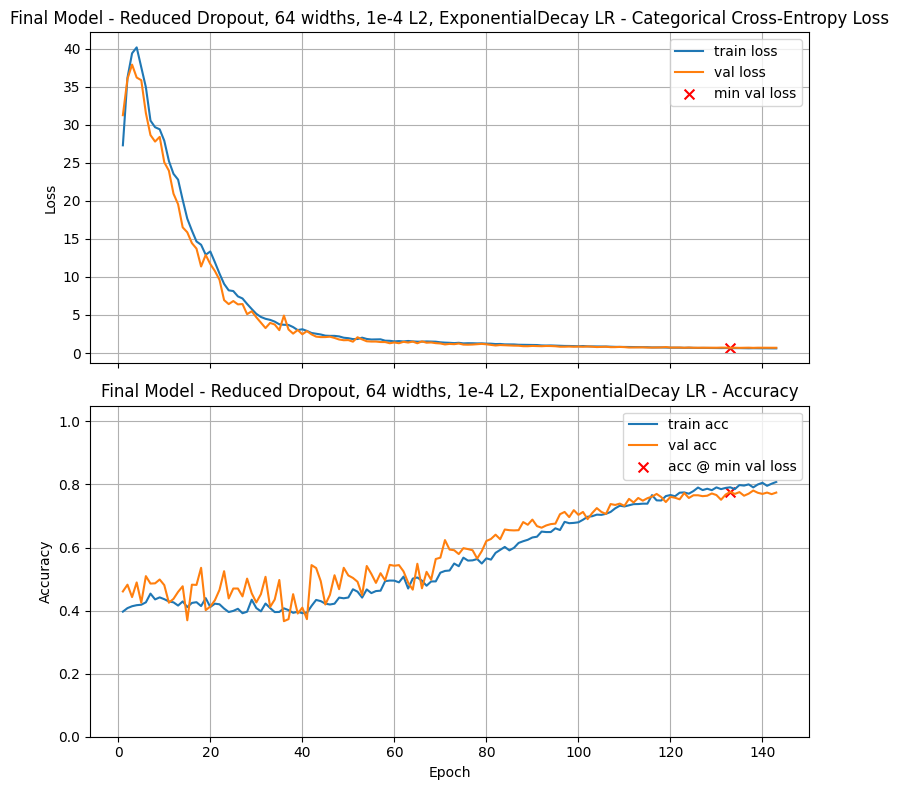

Final Training Loss:            0.6111
Final Training Accuracy:        0.8081
Final Validation Loss:          0.6893
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.6790 (Epoch 133)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.7418
Test Accuracy: 0.7457

Validation-Test Gap (accuracy): 0.030714

Execution Time: 00:00:45


In [41]:
# Your code here
model_final = build_model(X_train.shape[1], [ (64,best_act,1e-4,best_drop_64-0.1), (64,best_act,1e-4,best_drop_32-0.1)], n_classes)

train_and_test(model_final, lr_schedule=LR_schedule_,  title = f"Final Model - Reduced Dropout, 64 widths, 1e-4 L2, ExponentialDecay LR")

In [42]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7764             # Replace 0.0 with your answer

In [43]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a6 = {a6:.4f}')

a6 = 0.7764


### Optional: Print out your results of all experiments

In [44]:
print_results()

Baseline Model - L2_64 = 0.001, L2_32 = 0.001	0.7857
Baseline Model - DR_64 = 0.1, DR_32 = 0.4	0.7807
Baseline Model - L2_64 = 0.001, L2_32 = 0.0001	0.7807
Baseline Model - LR = 0.001             	0.7793
Baseline Model - TanH                   	0.7786
Baseline Model - LR = 0.0005            	0.7779
Baseline Model - L2_64 = 0.0001, L2_32 = 0.0001	0.7779
Final Model - Reduced Dropout, 64 widths, 1e-4 L2, ExponentialDecay LR	0.7764
Baseline Model - Sigmoid                	0.7757
Baseline Model - DR_64 = 0.0, DR_32 = 0.3	0.7736
Baseline Model - DR_64 = 0.1, DR_32 = 0.5	0.7736
Baseline Model - DR_64 = 0.1, DR_32 = 0.3	0.7700
Baseline Model - RelU                   	0.7693
Baseline Model - DR_64 = 0.0, DR_32 = 0.4	0.7686
Baseline Model - L2_64 = 0.0001, L2_32 = 0.001	0.7686
Baseline Model - L2_64 = 0.0001, L2_32 = 0.01	0.7686
Baseline Model w Reduced Dropout - L2 = 0.0001	0.7671
Baseline Model - L2_64 = 0.01, L2_32 = 0.001	0.7664
Baseline Model - DR_64 = 0.2, DR_32 = 0.4	0.7657
Baseline Mode

## Reflection Questions (ungraded)

It would be a great idea to think through your answers to these questions, then give ChatGPT (or other AI tool) a PDF of your
homework, and **discuss** (not just ask) these.

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?